In [1]:
%matplotlib inline

import rdkit # compchem library
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole # use this to draw molecules in the notebook
from rdkit import rdBase
print(rdkit.__version__)

import pandas as pd
import numpy as np

2023.03.3


Data for this exercise taken from the [DUD-E validation dataset](http://dude.docking.org/targets/try1).

In [2]:
def get_mols(smi_file):
    mols = []
    with open(smi_file) as f:
        for l in f:
            mols.append(l.split()[0])
    return mols

In [3]:
n = 200
actives = [ Chem.MolFromSmiles(m) for m in get_mols('./data/hivpr_actives_final.ism')[:n] ]
decoys = [ Chem.MolFromSmiles(m) for m in get_mols('./data/hivpr_decoys_final.ism')[:n] ]

query = actives[0]

df = pd.DataFrame()
df['molecule'] = actives[1:] + decoys
actual_class = ([1] * (len(actives)-1)) + ([0] * len(decoys))
df['class'] = actual_class
df

,molecule,class
0,<rdkit.Chem.rdchem.Mol object at 0x7f6d4877af10>,1
1,<rdkit.Chem.rdchem.Mol object at 0x7f6d4877af80>,1
2,<rdkit.Chem.rdchem.Mol object at 0x7f6d4877aff0>,1
3,<rdkit.Chem.rdchem.Mol object at 0x7f6d4877b060>,1
4,<rdkit.Chem.rdchem.Mol object at 0x7f6d4877b0d0>,1
...,...,...
394,<rdkit.Chem.rdchem.Mol object at 0x7f6d487aa1f0>,0
395,<rdkit.Chem.rdchem.Mol object at 0x7f6d487aa260>,0
396,<rdkit.Chem.rdchem.Mol object at 0x7f6d487aa2d0>,0
397,<rdkit.Chem.rdchem.Mol object at 0x7f6d487aa340>,0


In [4]:
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit import DataStructs

def get_fp(mol):
    return GetMorganFingerprint(mol, 2)

def sim(fp1, fp2):
    return DataStructs.DiceSimilarity(fp1, fp2)


query_fp = get_fp(query)

df['fp'] = df['molecule'].apply(get_fp) 
df['sim_score'] = df['fp'].apply(lambda x: sim(x, query_fp)) 
df2 = df.sort_values('sim_score', ascending=False)
df2
df.to_csv('fp_similarity.csv', sep='\t')

In [5]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(df2['class'], df2['sim_score'])
auc = metrics.roc_auc_score(df2['class'], df2['sim_score'])

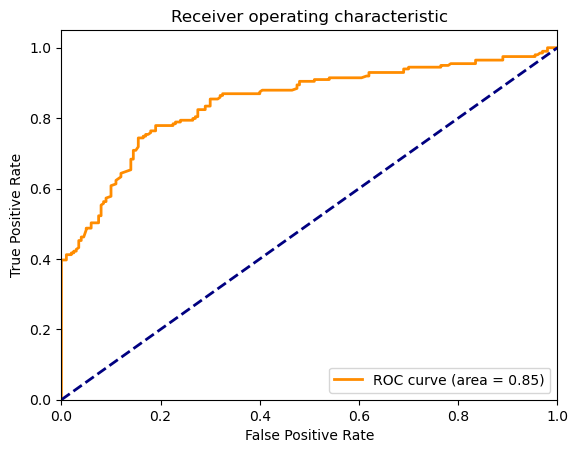

In [6]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Practical Tasks

* Can you build an ML model which out performs this unsophisticated search?
* How would you compare performance between the two models?